In [148]:
# 1 Initial Setup
import datetime
import numpy as np
import pandas as pd
import time
from jqdata import *
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import copy
import pickle

%matplotlib inline

# 定义类'参数分析'
class parameter_analysis(object):
    
    # 定义函数中不同的变量
    def __init__(self, algorithm_id=None):
        self.algorithm_id = algorithm_id            # 回测id
        
        self.params_df = pd.DataFrame()             # 回测中所有调参备选值的内容，列名字为对应修改面两名称，对应回测中的 g.XXXX
        self.results = {}                           # 回测结果的回报率，key 为 params_df 的行序号，value 为
        self.evaluations = {}                       # 回测结果的各项指标，key 为 params_df 的行序号，value 为一个 dataframe
        self.backtest_ids = {}                      # 回测结果的 id
        
        # 新加入的基准的回测结果 id，可以默认为空 ''，则使用回测中设定的基准
        self.benchmark_id = 'f16629492d6b6f4040b2546262782c78'                      
        
        self.benchmark_returns = []                 # 新加入的基准的回测回报率
        self.returns = {}                           # 记录所有回报率
        self.excess_returns = {}                    # 记录超额收益率
        self.log_returns = {}                       # 记录收益率的 log 值
        self.log_excess_returns = {}                # 记录超额收益的 log 值
        self.dates = []                             # 回测对应的所有日期
        self.excess_max_drawdown = {}               # 计算超额收益的最大回撤
        self.excess_annual_return = {}              # 计算超额收益率的年化指标
        self.evaluations_df = pd.DataFrame()        # 记录各项回测指标，除日回报率外
        self.failed_list= []
    
    # 定义排队运行多参数回测函数
    def run_backtest(self,                          #
                     algorithm_id=None,             # 回测策略id
                     running_max=10,                # 回测中同时巡行最大回测数量
                     start_date='2006-01-01',       # 回测的起始日期
                     end_date='2016-11-30',         # 回测的结束日期
                     frequency='day',               # 回测的运行频率
                     initial_cash='1000000',        # 回测的初始持仓金额
                     param_names=[],                # 回测中调整参数涉及的变量
                     param_values=[],               # 回测中每个变量的备选参数值
                     python_version = 2,            # 回测的python版本
                     use_credit =False              # 是否允许消耗积分继续回测
                     ):
        # 当此处回测策略的 id 没有给出时，调用类输入的策略 id
        if algorithm_id == None: algorithm_id=self.algorithm_id
        
        # 生成所有参数组合并加载到 df 中
        # 包含了不同参数具体备选值的排列组合中一组参数的 tuple 的 list
        param_combinations = list(itertools.product(*param_values))
        # 生成一个 dataframe， 对应的列为每个调参的变量，每个值为调参对应的备选值
        to_run_df = pd.DataFrame(param_combinations,dtype='object')
        # 修改列名称为调参变量的名字
        to_run_df.columns = param_names
        
        # 设定运行起始时间和保存格式
        start = time.time()
        # 记录结束的运行回测
        finished_backtests = {}
        # 记录运行中的回测
        running_backtests = {}
        # 计数器
        pointer = 0
        # 总运行回测数目，等于排列组合中的元素个数
        total_backtest_num = len(param_combinations)
        # 记录回测结果的回报率
        all_results = {}
        # 记录回测结果的各项指标
        all_evaluations = {}
        
        # 在运行开始时显示
        print(('【已完成|运行中|待运行】:'), end=' ')
        
        cannot_get = {} #获取失败 , 重试加一
        
        # 当运行回测开始后，如果没有全部运行完全的话：
        while len(finished_backtests)<total_backtest_num:
            # 显示运行、完成和待运行的回测个数
            print(('[%s|%s|%s].' % (len(finished_backtests), 
                                   len(running_backtests), 
                                   (total_backtest_num-len(finished_backtests)-len(running_backtests)) )), end=' ')
            # 记录当前运行中的空位数量
            to_run = min(running_max-len(running_backtests), total_backtest_num-len(running_backtests)-len(finished_backtests))
            # 把可用的空位进行跑回测
            for i in range(pointer, pointer+to_run):
                # 备选的参数排列组合的 df 中第 i 行变成 dict，每个 key 为列名字，value 为 df 中对应的值
                params = to_run_df.iloc[i].to_dict()
                # 记录策略回测结果的 id，调整参数 extras 使用 params 的内容
                backtest = create_backtest(algorithm_id = algorithm_id,
                                           start_date = start_date, 
                                           end_date = end_date, 
                                           frequency = frequency, 
                                           initial_cash = initial_cash, 
                                           extras = params, 
                                           # 再回测中把改参数的结果起一个名字，包含了所有涉及的变量参数值
                                           name = str(params),
                                           python_version = python_version,
                                           use_credit = use_credit
                                           )
                # 记录运行中 i 回测的回测 id
                running_backtests[i] = backtest
            # 计数器计数运行完的数量    
            pointer = pointer+to_run

            # 获取回测结果
            failed = []
            finished = []
            
            # 对于运行中的回测，key 为 to_run_df 中所有排列组合中的序数
            for key in list(running_backtests.keys()):
                # 研究调用回测的结果，running_backtests[key] 为运行中保存的结果 id
                try :
                    back_id = running_backtests[key]
                    bt = get_backtest(back_id)
                    # 获得运行回测结果的状态，成功和失败都需要运行结束后返回，如果没有返回则运行没有结束
                    status = bt.get_status()
                    # 当运行回测失败
                    if status == 'failed':
                        # 失败 list 中记录对应的回测结果 id
                        print('')
                        print(('回测失败 : https://www.joinquant.com/algorithm/backtest/detail?backtestId='+back_id))
                        failed.append(key) 
                    # 当运行回测成功时
                    elif status == 'done':
                        # 成功 list 记录对应的回测结果 id，finish 仅记录运行成功的
                        finished.append(key)
                        # 回测回报率记录对应回测的回报率 dict， key to_run_df 中所有排列组合中的序数， value 为回报率的 dict
                        # 每个 value 一个 list 每个对象为一个包含时间、日回报率和基准回报率的 dict
                        all_results[key] = bt.get_results()
                        # 回测回报率记录对应回测结果指标 dict， key to_run_df 中所有排列组合中的序数， value 为回测结果指标的 dataframe
                        all_evaluations[key] = bt.get_risk()
                            # 记录运行中回测结果 id 的 list 中删除失败的运行
                except Exception as e:
                    count = cannot_get.get( key)
                    if not count :
                        cannot_get[key] = 1
                        count = 0
                    elif count < 5:
                        cannot_get[key] = count +1
                    else :
                        failed.append(key) 
                    print("获取回测信息{}失败，重试 {} 次 , 共 {} 次 \n {} ".format(back_id, count ,5 ,e) )
                    time.sleep(2)
            # 记录运行中回测结果 id 的 list 中删除失败的运行
            for key in failed:
                finished_backtests[key] = running_backtests.pop(key)
            # 在结束回测结果 dict 中记录运行成功的回测结果 id，同时在运行中的记录中删除该回测
            for key in finished:
                finished_backtests[key] = running_backtests.pop(key)
#                 print (finished_backtests)
            # 当一组同时运行的回测结束时报告时间
            if len(finished_backtests) != 0 and len(finished_backtests) % running_max == 0 and to_run !=0:
                # 记录当时时间
                middle = time.time()
                # 计算剩余时间，假设没工作量时间相等的话
                remain_time = (middle - start) * (total_backtest_num - len(finished_backtests)) / len(finished_backtests)
                # print 当前运行时间
                print(('[已用%s时,尚余%s时,请不要关闭浏览器].' % (str(round((middle - start) / 60.0 / 60.0,3)), 
                                          str(round(remain_time / 60.0 / 60.0,3)))), end=' ')
            self.failed_list  += failed
            # 5秒钟后再跑一下
            time.sleep(5) 
        # 记录结束时间
        end = time.time() 
        print('')
        print(('【回测完成】总用时：%s秒(即%s小时)。' % (str(int(end-start)), 
                                           str(round((end-start)/60.0/60.0,2)))), end=' ')
#         print (to_run_df,all_results,all_evaluations,finished_backtests)
        # 对应修改类内部对应
#         to_run_df = {key:value for key,value in returns.items() if key not in faild}
        self.params_df = to_run_df
#         all_results = {key:value for key,value in all_results.items() if key not in faild}
        self.results = all_results
#         all_evaluations = {key:value for key,value in all_evaluations.items() if key not in faild}
        self.evaluations = all_evaluations
#         finished_backtests = {key:value for key,value in finished_backtests.items() if key not in faild}
        self.backtest_ids = finished_backtests

        
    #7 最大回撤计算方法
    def find_max_drawdown(self, returns):
        # 定义最大回撤的变量
        result = 0
        # 记录最高的回报率点
        historical_return = 0
        # 遍历所有日期
        for i in range(len(returns)):
            # 最高回报率记录
            historical_return = max(historical_return, returns[i])
            # 最大回撤记录
            drawdown = 1-(returns[i] + 1) / (historical_return + 1)
            # 记录最大回撤
            result = max(drawdown, result)
        # 返回最大回撤值
        return result

    # log 收益、新基准下超额收益和相对与新基准的最大回撤
    def organize_backtest_results(self, benchmark_id=None):
        # 若新基准的回测结果 id 没给出
        if benchmark_id==None:
            # 使用默认的基准回报率，默认的基准在回测策略中设定
            self.benchmark_returns = [x['benchmark_returns'] for x in self.results[0]]
        # 当新基准指标给出后    
        else:
            # 基准使用新加入的基准回测结果
            self.benchmark_returns = [x['returns'] for x in get_backtest(benchmark_id).get_results()]
        # 回测日期为结果中记录的第一项对应的日期
        self.dates = [x['time'] for x in self.results[0]]
        
        # 对应每个回测在所有备选回测中的顺序 （key），生成新数据
        # 由 {key：{u'benchmark_returns': 0.022480100091729405,
        #           u'returns': 0.03184566700000002,
        #           u'time': u'2006-02-14'}} 格式转化为：
        # {key: []} 格式，其中 list 为对应 date 的一个回报率 list
        for key in list(self.results.keys()):
            self.returns[key] = [x['returns'] for x in self.results[key]]
        # 生成对于基准（或新基准）的超额收益率
        for key in list(self.results.keys()):
            self.excess_returns[key] = [(x+1)/(y+1)-1 for (x,y) in zip(self.returns[key], self.benchmark_returns)]
        # 生成 log 形式的收益率
        for key in list(self.results.keys()):
            self.log_returns[key] = [log(x+1) for x in self.returns[key]]
        # 生成超额收益率的 log 形式
        for key in list(self.results.keys()):
            self.log_excess_returns[key] = [log(x+1) for x in self.excess_returns[key]]
        # 生成超额收益率的最大回撤
        for key in list(self.results.keys()):
            self.excess_max_drawdown[key] = self.find_max_drawdown(self.excess_returns[key])
        # 生成年化超额收益率
        for key in list(self.results.keys()):
            self.excess_annual_return[key] = (self.excess_returns[key][-1]+1)**(252./float(len(self.dates)))-1
        # 把调参数据中的参数组合 df 与对应结果的 df 进行合并
        self.evaluations_df = pd.concat([self.params_df, pd.DataFrame(self.evaluations).T], axis=1)
#         self.evaluations_df = 

    # 获取最总分析数据，调用排队回测函数和数据整理的函数    
    def get_backtest_data(self,
                          algorithm_id=None,                         # 回测策略id
                          benchmark_id=None,                         # 新基准回测结果id
                          file_name='results.pkl',                   # 保存结果的 pickle 文件名字
                          running_max=10,                            # 最大同时运行回测数量
                          start_date='2006-01-01',                   # 回测开始时间
                          end_date='2016-11-30',                     # 回测结束日期
                          frequency='day',                           # 回测的运行频率
                          initial_cash='1000000',                    # 回测初始持仓资金
                          param_names=[],                            # 回测需要测试的变量
                          param_values=[],                           # 对应每个变量的备选参数
                          python_version = 2,
                          use_credit = False
                          ):
        # 调运排队回测函数，传递对应参数
        self.run_backtest(algorithm_id=algorithm_id,
                          running_max=running_max,
                          start_date=start_date,
                          end_date=end_date,
                          frequency=frequency,
                          initial_cash=initial_cash,
                          param_names=param_names,
                          param_values=param_values,
                          python_version = python_version,
                          use_credit = use_credit,
                          )
        # 回测结果指标中加入 log 收益率和超额收益率等指标
        self.organize_backtest_results(benchmark_id)
        # 生成 dict 保存所有结果。
        results = {'returns':self.returns,
                   'excess_returns':self.excess_returns,
                   'log_returns':self.log_returns,
                   'log_excess_returns':self.log_excess_returns,
                   'dates':self.dates,
                   'benchmark_returns':self.benchmark_returns,
                   'evaluations':self.evaluations,
                   'params_df':self.params_df,
                   'backtest_ids':self.backtest_ids,
                   'excess_max_drawdown':self.excess_max_drawdown,
                   'excess_annual_return':self.excess_annual_return,
                   'evaluations_df':self.evaluations_df,
                    "failed_list" : self.failed_list}
        # 保存 pickle 文件
        pickle_file = open(file_name, 'wb')
        pickle.dump(results, pickle_file)
        pickle_file.close()

    # 读取保存的 pickle 文件，赋予类中的对象名对应的保存内容    
    def read_backtest_data(self, file_name='results.pkl'):
        pickle_file = open(file_name, 'rb')
        results = pickle.load(pickle_file)
        self.returns = results['returns']
        self.excess_returns = results['excess_returns']
        self.log_returns = results['log_returns']
        self.log_excess_returns = results['log_excess_returns']
        self.dates = results['dates']
        self.benchmark_returns = results['benchmark_returns']
        self.evaluations = results['evaluations']
        self.params_df = results['params_df']
        self.backtest_ids = results['backtest_ids']
        self.excess_max_drawdown = results['excess_max_drawdown']
        self.excess_annual_return = results['excess_annual_return']
        self.evaluations_df = results['evaluations_df']
        self.failed_list =  results['failed_list']
    # 回报率折线图    
    def plot_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in list(self.returns.keys()):
            ax.plot(list(range(len(self.returns[key]))), self.returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(list(range(len(self.benchmark_returns))), self.benchmark_returns, label='benchmark', c='k', linestyle='--') 
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.returns[0]))

    # 超额收益率图    
    def plot_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in list(self.returns.keys()):
            ax.plot(list(range(len(self.excess_returns[key]))), self.excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(list(range(len(self.benchmark_returns))), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('excess returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.excess_returns[0]))
        
    # log回报率图    
    def plot_log_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in list(self.returns.keys()):
            ax.plot(list(range(len(self.log_returns[key]))), self.log_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(list(range(len(self.benchmark_returns))), [log(x+1) for x in self.benchmark_returns], label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_returns[0]))
    
    # 超额收益率的 log 图
    def plot_log_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in list(self.returns.keys()):
            ax.plot(list(range(len(self.log_excess_returns[key]))), self.log_excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(list(range(len(self.benchmark_returns))), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log excess returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_excess_returns[0]))

        
    # 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
    def get_eval4_bar(self, sort_by=[]): 
        
        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        indices = set(sorted_params.index)-set(self.failed_list)
        fig = plt.figure(figsize=(20,7))

        # 定义位置
        ax1 = fig.add_subplot(221)
        # 设定横轴为对应分位，纵轴为对应指标
        ax1.bar(list(range(len(indices))), 
                [self.evaluations[x]['algorithm_return'] for x in indices], 0.6, label = 'Algorithm_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax1.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax1.set_ylabel('Algorithm_return', fontsize=15)
        # 设置y标签样式
        ax1.set_yticklabels([str(x*100)+'% 'for x in ax1.get_yticks()])
        # 设置图片标题样式
        ax1.set_title("Strategy's of Algorithm_return performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax2 = fig.add_subplot(224)
        # 设定横轴为对应分位，纵轴为对应指标
        ax2.bar(list(range(len(indices))), 
                [self.evaluations[x]['max_drawdown'] for x in indices], 0.6, label = 'Max_drawdown')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax2.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax2.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax2.set_yticklabels([str(x*100)+'% 'for x in ax2.get_yticks()])
        # 设置图片标题样式
        ax2.set_title("Strategy's of Max_drawdown performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax3 = fig.add_subplot(223)
        # 设定横轴为对应分位，纵轴为对应指标
        ax3.bar(list(range(len(indices))),
                [self.evaluations[x]['sharpe'] for x in indices], 0.6, label = 'Sharpe')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax3.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax3.set_ylabel('Sharpe', fontsize=15)
        # 设置x标签样式
        ax3.set_yticklabels([str(x*100)+'% 'for x in ax3.get_yticks()])
        # 设置图片标题样式
        ax3.set_title("Strategy's of Sharpe performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax4 = fig.add_subplot(222)
        # 设定横轴为对应分位，纵轴为对应指标
        ax4.bar(list(range(len(indices))), 
                [self.evaluations[x]['algorithm_volatility'] for x in indices], 0.6, label = 'Algorithm_volatility')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax4.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax4.set_ylabel('Algorithm_volatility', fontsize=15)
        # 设置x标签样式
        ax4.set_yticklabels([str(x*100)+'% 'for x in ax4.get_yticks()])
        # 设置图片标题样式
        ax4.set_title("Strategy's of Algorithm_volatility performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))
        
    #14 年化回报和最大回撤，正负双色表示
    def get_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        indices = set(sorted_params.index)-set(self.failed_list)
        # 大小
        fig = plt.figure(figsize = (20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],
               [-self.evaluations[x]['max_drawdown'] for x in indices], color = '#32CD32',  
                     width = 0.6, label = 'Max_drawdown', zorder=10)
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.evaluations[x]['annual_algo_return'] for x in indices], color = 'r', 
                     width = 0.6, label = 'Annual_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', 
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))


    #14 超额收益的年化回报和最大回撤
    # 加入新的benchmark后超额收益和
    def get_excess_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        indices = set(sorted_params.index)-set(self.failed_list)
        # 大小
        fig = plt.figure(figsize = (20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],
               [-self.excess_max_drawdown[x] for x in indices], color = '#32CD32',  
                     width = 0.6, label = 'Excess_max_drawdown')
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.excess_annual_return[x] for x in indices], color = 'r', 
                     width = 0.6, label = 'Excess_annual_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', 
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))
        
        
        
        

In [2]:
# 2. Strategy id 
pa = parameter_analysis('6c0f2e1db43ab6d286fd56aad409521b')

In [12]:
# 3. Backtesting for XSHG composition stocks
XSHG = get_index_stocks('000300.XSHG')

pa.get_backtest_data(file_name = 'results.pkl',  
                          running_max = 10,      
                          benchmark_id = None,   
                          start_date = '2022-01-01', #回测开始时间
                          end_date = '2022-11-01',   #回测结束时间
                          frequency = 'day',         
                          initial_cash = '2000000',  
                          param_names = ['security'],  #变量名称
                          param_values = [XSHG],  #变量对应的参数
                          python_version = 3,   
                          use_credit = True     
                          )

【已完成|运行中|待运行】: [0|0|300]. [0|10|290]. [2|8|290]. [已用0.006时,尚余0.161时,请不要关闭浏览器]. [10|2|288]. [11|9|280]. [13|8|279]. [已用0.012时,尚余0.17时,请不要关闭浏览器]. [20|3|277]. [22|8|270]. [25|7|268]. [已用0.019时,尚余0.17时,请不要关闭浏览器]. [30|5|265]. [33|7|260]. 
回测失败 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=29fda4d64ba9c4657e1f18e4ab3fb0bb
[37|6|257]. [41|6|253]. [44|7|249]. [47|7|246]. [52|5|243]. [56|6|238]. [已用0.038时,尚余0.15时,请不要关闭浏览器]. [60|6|234]. [63|7|230]. [67|6|227]. [71|6|223]. [73|8|219]. [77|6|217]. [81|6|213]. [84|7|209]. [87|7|206]. [92|5|203]. [94|8|198]. [97|7|196]. [已用0.064时,尚余0.129时,请不要关闭浏览器]. [100|7|193]. [104|6|190]. [108|6|186]. [已用0.071时,尚余0.123时,请不要关闭浏览器]. [110|8|182]. [116|4|180]. [119|7|174]. [122|7|171]. [125|7|168]. [131|4|165]. [133|8|159]. [137|6|157]. [142|5|153]. [144|8|148]. [148|6|146]. [152|6|142]. [155|7|138]. [已用0.1时,尚余0.088时,请不要关闭浏览器]. [160|5|135]. [164|6|130]. [168|6|126]. [171|7|122]. [175|6|119]. [178|7|115]. [181|7|112]. [185|6|109]. [189|6|105]. 
回测失败

In [13]:
# 4. Read in the Data
pa.read_backtest_data('results.pkl')

In [147]:
## 5. Setup & Cleaning
df = pa.evaluations_df
df_cleaned = df.dropna()

## 5.1 type casting
df_cleaned = df_cleaned.apply(pd.to_numeric, errors='coerce', downcast='float')
# df_cleaned.info()
print("本次分析使用沪深300的成分股，使用双均值交易策略。以下为回测结果。")
print("在数据清理以后一共有 %d non-null rows." % len(df_cleaned))
df_cleaned.head(20)

本次分析使用沪深300的成分股，使用双均值交易策略。以下为回测结果。
在数据清理以后一共有 248 non-null rows.


,__version,algorithm_return,algorithm_volatility,alpha,annual_algo_return,annual_bm_return,avg_excess_return,avg_position_days,avg_trade_return,benchmark_return,benchmark_volatility,beta,day_win_ratio,excess_return,excess_return_max_drawdown,excess_return_max_drawdown_period,excess_return_sharpe,information,lose_count,max_drawdown,max_drawdown_period,max_leverage,period_label,profit_loss_ratio,sharpe,sortino,trading_days,treasury_return,turnover_rate,win_count,win_ratio
security,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000002.XSHE,101.0,0.057709,0.278749,0.147854,0.073028,-0.320062,0.002011,91.0,0.008228,-0.264393,0.207698,0.318907,0.487437,0.437873,0.240717,NaN,1.758998,1.286744,10.0,0.185420,NaN,0.0,NaN,1.283914,0.118486,0.180114,199.0,0.032986,0.074358,5.0,0.333333
000063.XSHE,101.0,-0.366985,0.194417,-0.343262,-0.436984,-0.320062,-0.000656,89.0,-0.019477,-0.264393,0.207698,0.371389,0.452261,-0.139465,0.252094,NaN,-0.954057,-0.528775,18.0,0.390781,NaN,0.0,NaN,0.161924,-2.453413,-2.538892,199.0,0.032986,0.107151,3.0,0.142857
000069.XSHE,101.0,-0.169697,0.258162,-0.143878,-0.208341,-0.320062,0.000777,64.0,-0.008841,-0.264393,0.207698,0.290125,0.492462,0.128732,0.224274,NaN,0.425619,0.383752,13.0,0.296147,NaN,0.0,NaN,0.632236,-0.961956,-1.180396,199.0,0.032986,0.080143,3.0,0.187500
000157.XSHE,101.0,-0.231201,0.158969,-0.261006,-0.281299,-0.320062,0.000329,87.0,-0.012953,-0.264393,0.207698,0.167452,0.492462,0.045122,0.242636,NaN,0.072936,0.166867,14.0,0.275156,NaN,0.0,NaN,0.218565,-2.021137,-2.688365,199.0,0.032986,0.086511,3.0,0.176471
000166.XSHE,101.0,-0.224125,0.130099,-0.254028,-0.272979,-0.320062,0.000360,82.0,-0.010892,-0.264393,0.207698,0.163724,0.517588,0.054741,0.208653,NaN,0.135861,0.219672,18.0,0.224125,NaN,0.0,NaN,0.184950,-2.405695,-3.141258,199.0,0.032986,0.100864,2.0,0.100000
000301.XSHE,101.0,0.017850,0.364644,0.007258,0.022476,-0.320062,0.001969,79.0,0.007116,-0.264393,0.207698,0.068827,0.552764,0.383688,0.308671,NaN,1.120906,0.830372,12.0,0.304795,NaN,0.0,NaN,1.090332,-0.048058,-0.068466,199.0,0.032986,0.078713,4.0,0.250000
000333.XSHE,101.0,-0.284330,0.187896,-0.301833,-0.343131,-0.320062,-0.000020,76.0,-0.013896,-0.264393,0.207698,0.225792,0.487437,-0.027103,0.299129,NaN,-0.303287,-0.095007,18.0,0.328748,NaN,0.0,NaN,0.231286,-2.039057,-2.490519,199.0,0.032986,0.105139,3.0,0.142857
000408.XSHE,101.0,-0.201675,0.310015,-0.199566,-0.246453,-0.320062,0.000649,91.0,-0.007745,-0.264393,0.207698,0.241311,0.552764,0.085261,0.215793,NaN,0.197890,0.213895,12.0,0.236631,NaN,0.0,NaN,0.646616,-0.923999,-1.168829,199.0,0.032986,0.091404,6.0,0.333333
000425.XSHE,101.0,-0.100436,0.162140,-0.112644,-0.124510,-0.320062,0.001125,99.0,-0.007217,-0.264393,0.207698,0.144046,0.537688,0.222887,0.185926,NaN,1.034084,0.819077,14.0,0.174948,NaN,0.0,NaN,0.467652,-1.014612,-1.474687,199.0,0.032986,0.082832,2.0,0.125000


In [142]:
# 6. Some descriptives
highest_return_stock = df_cleaned['algorithm_return'].idxmax()
print("Stock with highest algorithm return: %s."% get_security_info(highest_return_stock).display_name)

lowest_return_stock = df_cleaned['algorithm_return'].idxmin()
print("Stock with lowest algorithm return: %s."% get_security_info(lowest_return_stock).display_name)

df_cleaned.describe()

Stock with highest algorithm return: 德业股份.
Stock with lowest algorithm return: 立讯精密.


,__version,algorithm_return,algorithm_volatility,alpha,annual_algo_return,annual_bm_return,avg_excess_return,avg_position_days,avg_trade_return,benchmark_return,benchmark_volatility,beta,day_win_ratio,excess_return,excess_return_max_drawdown,excess_return_max_drawdown_period,excess_return_sharpe,information,lose_count,max_drawdown,max_drawdown_period,max_leverage,period_label,profit_loss_ratio,sharpe,sortino,trading_days,treasury_return,turnover_rate,win_count,win_ratio
count,248.0,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,248.000000,248.000000,2.480000e+02,2.480000e+02,248.000000,248.000000,248.000000,248.000000,0.0,248.000000,248.000000,248.000000,248.000000,0.0,248.0,0.0,248.000000,248.000000,248.000000,248.0,2.480000e+02,248.000000,248.000000,248.000000
mean,101.0,-0.156495,0.240399,-0.127333,-0.187035,-3.200609e-01,0.000757,83.229836,-0.007633,-2.643930e-01,2.076985e-01,0.276903,0.505836,0.146680,0.221225,NaN,0.511137,0.447369,13.076612,0.262262,NaN,0.0,NaN,0.564046,-1.082723,-1.235799,199.0,3.298626e-02,0.085221,3.858871,0.224677
std,0.0,0.175705,0.097769,0.212340,0.215340,7.167022e-07,0.001043,22.522177,0.012628,1.791755e-07,5.076640e-07,0.146237,0.028648,0.238858,0.068311,NaN,0.983253,0.670250,4.374912,0.106714,NaN,0.0,NaN,0.457883,0.933896,1.109986,0.0,3.732824e-08,0.023858,1.671458,0.105168
min,101.0,-0.522511,0.000000,-0.520056,-0.604918,-3.200616e-01,-0.001981,0.000000,-0.034707,-2.643932e-01,2.076980e-01,-0.049092,0.432161,-0.350892,0.087436,NaN,-1.564810,-0.962372,0.000000,0.000000,NaN,0.0,NaN,0.000000,-3.742937,-4.418666,199.0,3.298630e-02,0.000000,0.000000,0.000000
25%,101.0,-0.265619,0.182378,-0.261010,-0.321484,-3.200616e-01,0.000178,77.000000,-0.014394,-2.643932e-01,2.076980e-01,0.173556,0.487437,-0.001666,0.168164,NaN,-0.133556,-0.004618,10.750000,0.199495,NaN,0.0,NaN,0.264544,-1.691599,-1.893072,199.0,3.298630e-02,0.077159,3.000000,0.166667
50%,101.0,-0.169211,0.247423,-0.157264,-0.207758,-3.200616e-01,0.000757,85.000000,-0.008334,-2.643932e-01,2.076980e-01,0.276997,0.502513,0.129393,0.215426,NaN,0.426681,0.388626,13.000000,0.264645,NaN,0.0,NaN,0.466960,-1.142682,-1.356507,199.0,3.298630e-02,0.086182,4.000000,0.222222
75%,101.0,-0.068029,0.303775,-0.040000,-0.084705,-3.200616e-01,0.001360,95.000000,-0.002291,-2.643932e-01,2.076980e-01,0.375253,0.522613,0.266942,0.264044,NaN,1.083848,0.839406,16.000000,0.325071,NaN,0.0,NaN,0.716491,-0.481178,-0.642075,199.0,3.298630e-02,0.098983,5.000000,0.294118
max,101.0,0.490470,0.501066,0.714859,0.650983,-3.200616e-01,0.004084,124.000000,0.053399,-2.643932e-01,2.076980e-01,0.672282,0.577889,1.026177,0.433370,NaN,3.244434,2.282936,23.000000,0.543378,NaN,0.0,NaN,2.661139,1.316836,2.027950,199.0,3.298630e-02,0.140344,9.000000,0.562500


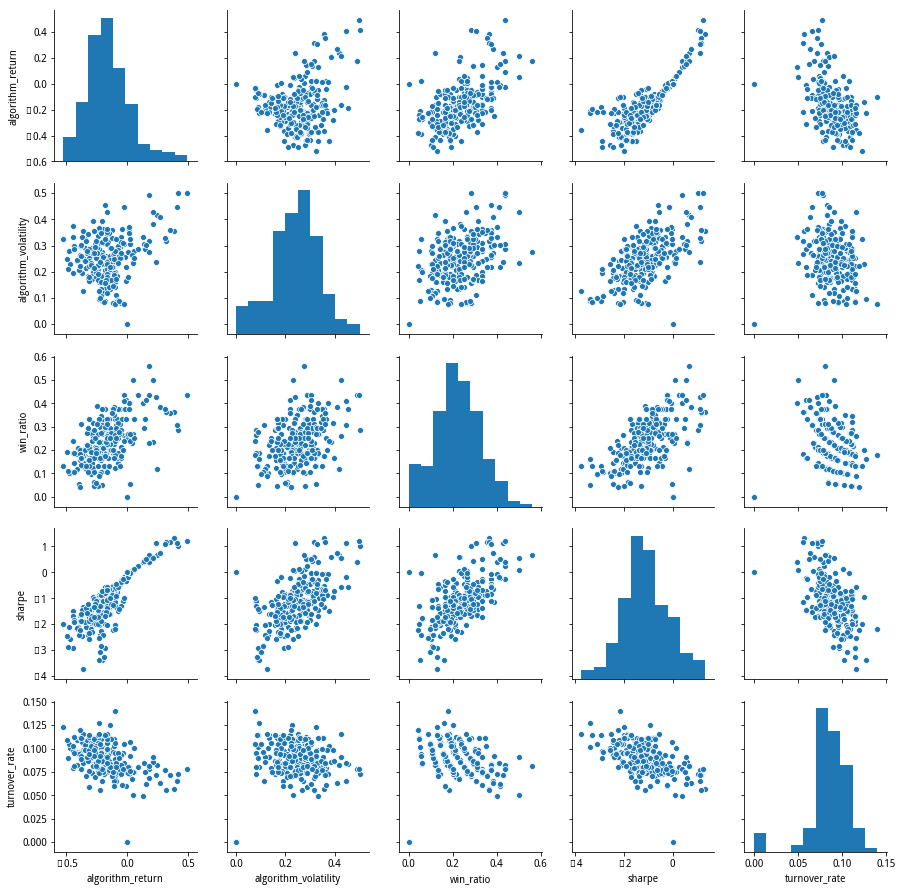

The scatter plot matrix shows a positive relation between the algo return and algo volatility as well as Sharpe ratio. The algorithm works better with stocks with higher volatility (more risky)


In [50]:
# Exloratory Data Analysis
%matplotlib inline

# 7. Pairplot
sns.pairplot(df_cleaned.loc[:,['algorithm_return','algorithm_volatility','win_ratio','sharpe','turnover_rate']])
plt.show()

print("The scatter plot matrix shows a positive relation between the algo return and algo volatility as well as Sharpe ratio. The algorithm works better with stocks with higher volatility (more risky)")


In [128]:

print("The average return of the algorithm is: %.4f%%" % np.multiply(df_cleaned['algorithm_return'].mean(),100))
print("The baseline return is: %.4f%%" % np.multiply(df_cleaned['benchmark_return'].mean(),100))
print("双均值 algorithm outperforms the benchmark.")


The average return of the algorithm is: -15.6495%
The baseline return is: -26.4393%
双均值 algorithm outperforms the benchmark.


In [92]:
## 8 加入行业code & name

ind_name = []
ind_code = []

def get_ind_name(df, stock):
    ind_dict = get_industry(security=[stock], date="2022-11-01")
    return ind_dict[stock]['jq_l1']['industry_name']

def get_ind_code(df, stock):
    ind_dict = get_industry(security=[stock], date="2022-11-01")
    return ind_dict[stock]['jq_l1']['industry_code']

 
for stock in df_cleaned.index:
    ind_name.append(get_ind_name(df_cleaned, stock))
    ind_code.append(get_ind_code(df_cleaned, stock))

df_cleaned['ind_name']=ind_name
df_cleaned['ind_code']=ind_code
    

数据中有 11 industries.
能源产业在此期间平均回报率最高，其次是金融产业等。总体各行业回报率都偏低。


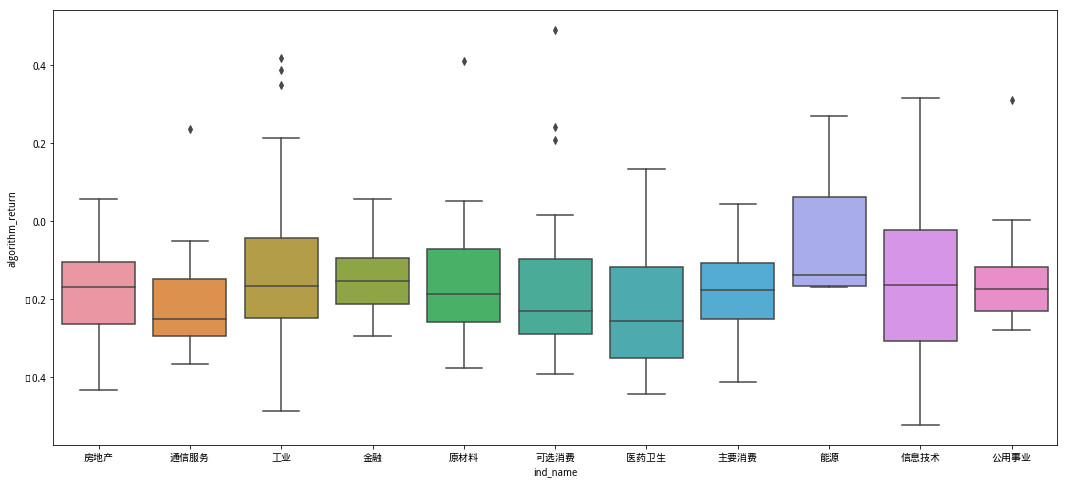

In [126]:
## 8.1 Box plot by industries

print("数据中有 %d industries." % len(set(df_cleaned['ind_code'])))
plt.figure(figsize=(18,8))
sns.boxplot(x=df_cleaned['ind_name'], y=df_cleaned['algorithm_return'])
print("能源产业在此期间平均回报率最高，其次是金融产业等。总体各行业回报率都偏低。")



In [125]:
## 高回报率股票产业

# indicator variable
mean_return = df_cleaned['algorithm_return'].mean()
outperform_stock = df_cleaned['algorithm_return'] > mean_return

# masking
outperform_stocks = df_cleaned[outperform_stock]
print("There are %d stocks outperforms the average algorithm return. \n The breakdown:" % len(outperform_stocks))
print ([[i, outperform_stocks['ind_name'].tolist().count(i)] for i in set(outperform_stocks['ind_name'].tolist())])
outperform_stocks
print("，在其中工业股票最多，其次为金融，信息技术，能源等。")


There are 108 stocks outperforms the average algorithm return. 
 The breakdown:
[['原材料', 10], ['能源', 5], ['工业', 27], ['通信服务', 2], ['主要消费', 7], ['可选消费', 7], ['医药卫生', 9], ['房地产', 2], ['金融', 20], ['公用事业', 4], ['信息技术', 15]]
，在其中工业股票最多，其次为金融，信息技术，能源等。
